In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Load metadata
metadata_path = '../Data/HAM/HAM10000_metadata_with_masks.csv'
metadata_df = pd.read_csv(metadata_path)

# Take a sample of the data
sample_size = 100  # Adjust the sample size as needed
metadata_sample = metadata_df.sample(n=sample_size, random_state=42)

# One-hot encode all categorical variables, including dx
metadata_sample = pd.get_dummies(metadata_sample, columns=['dx', 'dx_type', 'sex', 'localization', 'dataset'])

# Extract the target variable (one-hot encoded columns for dx will now be the target)
target_columns = [col for col in metadata_sample.columns if col.startswith('dx_')]
y = metadata_sample[target_columns].values

# Function to load images
def load_image(img_path, target_size=(650, 400)):
    try:
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        return img_array
    except Exception as e:
        print(f"Error loading image: {img_path}, error: {e}")
        return np.zeros(target_size + (3,))  # Return an empty array on error

# Load images, masks, and metadata
image_dir = '../Data/HAM/ham_images/'
mask_dir = '../Data/HAM/output_images/'

images = []
masks = []
metadata = []

for idx, row in metadata_sample.iterrows():
    image_id = row['image_id']
    mask_id = row['mask_id']
    
    image_path = f"{image_dir}/{image_id}.jpg"
    mask_path = f"{mask_dir}/{mask_id}.png"  # Assuming masks are in PNG format
    
    images.append(load_image(image_path))
    masks.append(load_image(mask_path))
    metadata.append(row.drop(target_columns + ['image_id', 'mask_id', 'lesion_id']).values)  # Drop unnecessary columns

images = np.array(images)
masks = np.array(masks)
metadata = np.array(metadata)

# Ensure all remaining columns are numeric
metadata_sample = metadata_sample.drop(columns=['image_id', 'mask_id', 'lesion_id'] + target_columns)
metadata_sample = metadata_sample.apply(pd.to_numeric, errors='coerce')

# Convert all columns to numeric explicitly
metadata_sample = metadata_sample.astype(float)

# Check for any remaining non-numeric columns
non_numeric_columns = metadata_sample.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_columns) > 0:
    raise ValueError(f"Non-numeric columns found: {non_numeric_columns}")

# Convert the DataFrame to a NumPy array
metadata = metadata_sample.values

# Check the shapes and types of all arrays before training
print(f"Images shape: {images.shape}, dtype: {images.dtype}")
print(f"Masks shape: {masks.shape}, dtype: {masks.dtype}")
print(f"Metadata shape: {metadata.shape}, dtype: {metadata.dtype}")
print(f"Target shape: {y.shape}, dtype: {y.dtype}")

# Split data into training and testing sets
X_img_train, X_img_test, X_mask_train, X_mask_test, X_meta_train, X_meta_test, y_train, y_test = train_test_split(
    images, masks, metadata, y, test_size=0.2, random_state=42)

# Define and compile a simplified model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout

image_input = Input(shape=(650, 400, 3), name='image_input')
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
image_output = Dense(128, activation='relu')(x)

mask_input = Input(shape=(650, 400, 3), name='mask_input')
y = Conv2D(32, (3, 3), activation='relu')(mask_input)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)
y = Flatten()(y)
mask_output = Dense(128, activation='relu')(y)

meta_input = Input(shape=(metadata.shape[1],), name='meta_input')
z = Dense(64, activation='relu')(meta_input)
meta_output = Dense(32, activation='relu')(z)

combined = Concatenate()([image_output, mask_output, meta_output])
combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.5)(combined)
combined_output = Dense(len(target_columns), activation='softmax')(combined)  # Adjust for multi-class classification

model = Model(inputs=[image_input, mask_input, meta_input], outputs=combined_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Train the model with the sample data
history = model.fit(
    [X_img_train, X_mask_train, X_meta_train], y_train,
    validation_data=([X_img_test, X_mask_test, X_meta_test], y_test),
    epochs=50,
    batch_size=32
)

Images shape: (100, 650, 400, 3), dtype: float32
Masks shape: (100, 650, 400, 3), dtype: float32
Metadata shape: (100, 19), dtype: float64
Target shape: (100, 9), dtype: bool


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 650, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 650, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 648, 398,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 648, 398,  │        896 │ mask_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 324, 199,  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 324, 199,  │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 322, 197,  │     18,496 │ max_pooling2d_16… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 322, 197,  │     18,496 │ max_pooling2d_18… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 161, 98,   │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 161, 98,   │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 1009792)   │          0 │ max_pooling2d_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 1009792)   │          0 │ max_pooling2d_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │      1,280 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 128)       │ 129,253,5… │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 128)       │ 129,253,5… │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 32)        │      2,080 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 288)       │          0 │ dense_24[0][0],   │
│ (Concatenate)       │                   │            │ dense_25[0][0],   │
│                     │                   │            │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 258,587,305 (986.43 MB)

 Trainable params: 258,587,305 (986.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.0672 - loss: 47.2495 - val_accuracy: 0.7500 - val_loss: 82.9354
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.3859 - loss: 96.9147 - val_accuracy: 0.0000e+00 - val_loss: 82.4733
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.1336 - loss: 154.2801 - val_accuracy: 0.6500 - val_loss: 200.8200
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.3055 - loss: 377.2705 - val_accuracy: 0.7500 - val_loss: 719.4198
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.3625 - loss: 1030.8846 - val_accuracy: 0.7500 - val_loss: 1545.2266
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.3961 - loss: 2536.3538 - val_accuracy: 0.6500 - val_loss: 2193.8464
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.2391 - loss: 4922.4819 - val_accuracy: 0.6500 - val_loss: 5099.1514
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.3141 - loss: 10791.4277 - val_accura

In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load metadata
metadata_path = '../Data/HAM/HAM10000_metadata_with_masks.csv'
metadata_df = pd.read_csv(metadata_path)

# Take a sample of the data
sample_size = 1000  # Adjust the sample size as needed
metadata_sample = metadata_df.sample(n=sample_size, random_state=42)

# One-hot encode all categorical variables, including dx
metadata_sample = pd.get_dummies(metadata_sample, columns=['dx', 'dx_type', 'sex', 'localization', 'dataset'])

# Extract the target variable (one-hot encoded columns for dx will now be the target)
target_columns = [col for col in metadata_sample.columns if col.startswith('dx_')]
y = metadata_sample[target_columns].values

# Function to load images
def load_image(img_path, target_size=(128, 128)):
    try:
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        return img_array
    except Exception as e:
        print(f"Error loading image: {img_path}, error: {e}")
        return np.zeros(target_size + (3,))  # Return an empty array on error

# Load images, masks, and metadata
image_dir = '../Data/HAM/ham_images/'
mask_dir = '../Data/HAM/output_images/'

images = []
masks = []
metadata = []

for idx, row in metadata_sample.iterrows():
    image_id = row['image_id']
    mask_id = row['mask_id']
    
    image_path = f"{image_dir}/{image_id}.jpg"
    mask_path = f"{mask_dir}/{mask_id}.png"  # Assuming masks are in PNG format
    
    images.append(load_image(image_path))
    masks.append(load_image(mask_path))
    metadata.append(row.drop(target_columns + ['image_id', 'mask_id', 'lesion_id']).values)  # Drop unnecessary columns

images = np.array(images)
masks = np.array(masks)
metadata = np.array(metadata)

# Ensure all remaining columns are numeric
metadata_sample = metadata_sample.drop(columns=['image_id', 'mask_id', 'lesion_id'] + target_columns)
metadata_sample = metadata_sample.apply(pd.to_numeric, errors='coerce')

# Convert all columns to numeric explicitly
metadata_sample = metadata_sample.astype(float)

# Standardize metadata
scaler = StandardScaler()
metadata = scaler.fit_transform(metadata_sample)

# Check the shapes and types of all arrays before training
print(f"Images shape: {images.shape}, dtype: {images.dtype}")
print(f"Masks shape: {masks.shape}, dtype: {masks.dtype}")
print(f"Metadata shape: {metadata.shape}, dtype: {metadata.dtype}")
print(f"Target shape: {y.shape}, dtype: {y.dtype}")

# Split data into training and testing sets
X_img_train, X_img_test, X_mask_train, X_mask_test, X_meta_train, X_meta_test, y_train, y_test = train_test_split(
    images, masks, metadata, y, test_size=0.2, random_state=42)

# Define and compile a simplified model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

image_input = Input(shape=(128, 128, 3), name='image_input')
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
image_output = Dense(128, activation='relu')(x)

mask_input = Input(shape=(128, 128, 3), name='mask_input')
y = Conv2D(32, (3, 3), activation='relu')(mask_input)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)
y = Flatten()(y)
mask_output = Dense(128, activation='relu')(y)

meta_input = Input(shape=(metadata.shape[1],), name='meta_input')
z = Dense(64, activation='relu')(meta_input)
meta_output = Dense(32, activation='relu')(z)

combined = Concatenate()([image_output, mask_output, meta_output])
combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.5)(combined)
combined_output = Dense(len(target_columns), activation='softmax')(combined)  # Adjust for multi-class classification

# Compile model with a smaller learning rate
model = Model(inputs=[image_input, mask_input, meta_input], outputs=combined_output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Train the model with the sample data
history = model.fit(
    [X_img_train, X_mask_train, X_meta_train], y_train,
    validation_data=([X_img_test, X_mask_test, X_meta_test], y_test),
    epochs=20,
    batch_size=32
)

Images shape: (1000, 128, 128, 3), dtype: float32
Masks shape: (1000, 128, 128, 3), dtype: float32
Metadata shape: (1000, 23), dtype: float64
Target shape: (1000, 11), dtype: bool


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 126, 126,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 126, 126,  │        896 │ mask_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 63, 63,    │          0 │ conv2d_32[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_34    │ (None, 63, 63,    │          0 │ conv2d_34[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 61, 61,    │     18,496 │ max_pooling2d_32… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 61, 61,    │     18,496 │ max_pooling2d_34… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 30, 30,    │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_35    │ (None, 30, 30,    │          0 │ conv2d_35[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 57600)     │          0 │ max_pooling2d_33… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_17          │ (None, 57600)     │          0 │ max_pooling2d_35… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 64)        │      1,536 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 128)       │  7,372,928 │ flatten_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 128)       │  7,372,928 │ flatten_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 32)        │      2,080 │ dense_50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 288)       │          0 │ dense_48[0][0],   │
│ (Concatenate)       │                   │            │ dense_49[0][0], 

 Total params: 14,826,667 (56.56 MB)

 Trainable params: 14,826,667 (56.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.0333 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.0260 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.0156 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.0370 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.0278 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.0302 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.0318 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.0302 - loss: nan

KeyboardInterrupt: 

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load metadata
metadata_path = '../Data/HAM/HAM10000_metadata_with_masks.csv'
metadata_df = pd.read_csv(metadata_path)

# Take a sample of the data
sample_size = 1000  # Adjust the sample size as needed
metadata_sample = metadata_df.sample(n=sample_size, random_state=42)

# One-hot encode all categorical variables, including dx
metadata_sample = pd.get_dummies(metadata_sample, columns=['dx', 'dx_type', 'sex', 'localization', 'dataset'])

# Extract the target variable (one-hot encoded columns for dx will now be the target)
target_columns = [col for col in metadata_sample.columns if col.startswith('dx_')]
y = metadata_sample[target_columns].values

# Function to load images
def load_image(img_path, target_size=(128, 128)):
    try:
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        return img_array
    except Exception as e:
        print(f"Error loading image: {img_path}, error: {e}")
        return np.zeros(target_size + (3,))  # Return an empty array on error

# Load images and metadata
image_dir = '../Data/HAM/ham_images/'

images = []
metadata = []

for idx, row in metadata_sample.iterrows():
    image_id = row['image_id']
    
    image_path = f"{image_dir}/{image_id}.jpg"
    
    images.append(load_image(image_path))
    metadata.append(row.drop(target_columns + ['image_id', 'mask_id', 'lesion_id']).values)  # Drop unnecessary columns

images = np.array(images)
metadata = np.array(metadata)

# Ensure all remaining columns are numeric
metadata_sample = metadata_sample.drop(columns=['image_id', 'mask_id', 'lesion_id'] + target_columns)
metadata_sample = metadata_sample.apply(pd.to_numeric, errors='coerce')

# Convert all columns to numeric explicitly
metadata_sample = metadata_sample.astype(float)

# Standardize metadata
scaler = StandardScaler()
metadata = scaler.fit_transform(metadata_sample)

# Check the shapes and types of all arrays before training
print(f"Images shape: {images.shape}, dtype: {images.dtype}")
print(f"Metadata shape: {metadata.shape}, dtype: {metadata.dtype}")
print(f"Target shape: {y.shape}, dtype: {y.dtype}")

# Split data into training and testing sets
X_img_train, X_img_test, X_meta_train, X_meta_test, y_train, y_test = train_test_split(
    images, metadata, y, test_size=0.2, random_state=42)

# Define and compile a simplified model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

# CNN for image input
image_input = Input(shape=(128, 128, 3), name='image_input')
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
image_output = Dense(128, activation='relu')(x)

# MLP for metadata input
meta_input = Input(shape=(metadata.shape[1],), name='meta_input')
z = Dense(64, activation='relu')(meta_input)
meta_output = Dense(32, activation='relu')(z)

# Combine both outputs
combined = Concatenate()([image_output, meta_output])
combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.5)(combined)
combined_output = Dense(len(target_columns), activation='softmax')(combined)  # Adjust for multi-class classification

# Compile model
model = Model(inputs=[image_input, meta_input], outputs=combined_output)
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Train the model with the sample data
history = model.fit(
    [X_img_train, X_meta_train], y_train,
    validation_data=([X_img_test, X_meta_test], y_test),
    epochs=50,
    batch_size=16
)

Images shape: (1000, 128, 128, 3), dtype: float32
Metadata shape: (1000, 23), dtype: float64
Target shape: (1000, 11), dtype: bool


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 126, 126,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 63, 63,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 30, 30,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 57600)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      1,536 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │  7,372,928 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 160)       │          0 │ dense_5[0][0],    │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     20,608 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 11)        │      1,419 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,417,963 (28.30 MB)

 Trainable params: 7,417,963 (28.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.0303 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.0290 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.0369 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.0374 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.0375 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.0398 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.0388 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.0282 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━

Images shape: (2000, 160, 160, 3), dtype: float32
Metadata shape: (2000, 23), dtype: float64
Target shape: (2000, 11), dtype: bool


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 160, 160,  │          0 │ image_input[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_2       │ (None, 160, 160,  │          0 │ sequential_2[0][… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_2          │ (None, 160, 160,  │          0 │ true_divide_2[0]… │
│ (Subtract)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_1… │ (None, 5, 5,      │  2,257,984 │ subtract_2[0][0]  │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │      1,536 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │    163,968 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │      2,080 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 160)       │          0 │ dense_20[0][0],   │
│ (Concatenate)       │                   │            │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 128)       │     20,608 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 11)        │      1,419 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,447,595 (9.34 MB)

 Trainable params: 189,611 (740.67 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 0.1290 - loss: nan - val_accuracy: 0.0325 - val_loss: nan
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.0295 - loss: nan - val_accuracy: 0.0325 - val_loss: nan
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.0375 - loss: nan - val_accuracy: 0.0325 - val_loss: nan
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.0325 - loss: nan - val_accuracy: 0.0325 - val_loss: nan
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.0274 - loss: nan - val_accuracy: 0.0325 - val_loss: nan
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.0276 - loss: nan - val_accuracy: 0.0325 - val_loss: nan
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.0303 - loss: nan - val_accuracy: 0.0325 - val_loss: nan
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.0481 - loss: nan - val_accuracy: 0.0325 - val_loss: nan
Epoch 9/15
50/50 ━━━━━━

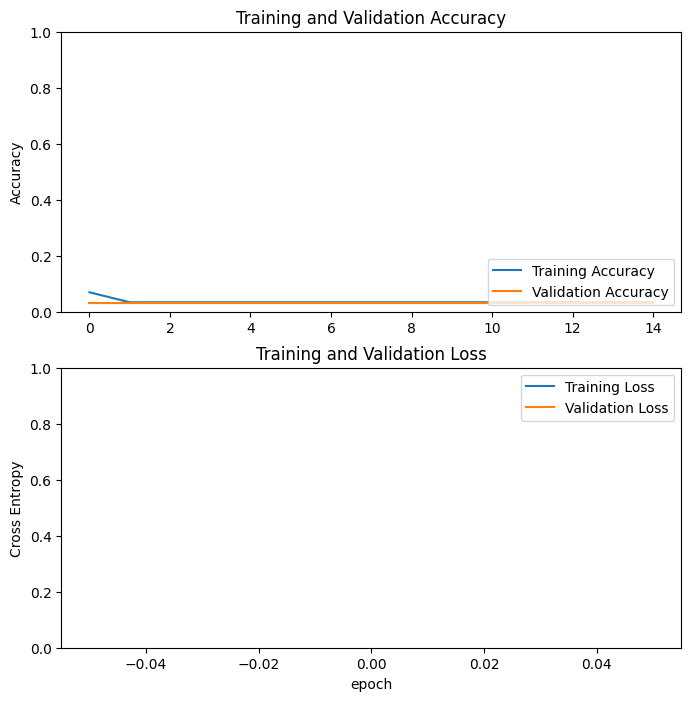

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load metadata
metadata_path = '../Data/HAM/HAM10000_metadata_with_masks.csv'
metadata_df = pd.read_csv(metadata_path)

# Take a sample of the data
sample_size = 2000  # Adjust the sample size as needed
metadata_sample = metadata_df.sample(n=sample_size, random_state=42)

# One-hot encode all categorical variables, including dx
metadata_sample = pd.get_dummies(metadata_sample, columns=['dx', 'dx_type', 'sex', 'localization', 'dataset'])

# Extract the target variable (one-hot encoded columns for dx will now be the target)
target_columns = [col for col in metadata_sample.columns if col.startswith('dx_')]
y = metadata_sample[target_columns].values

# Function to load images
def load_image(img_path, target_size=(160, 160)):
    try:
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        return img_array
    except Exception as e:
        print(f"Error loading image: {img_path}, error: {e}")
        return np.zeros(target_size + (3,))  # Return an empty array on error

# Load images and metadata
image_dir = '../Data/HAM/ham_images/'

images = []
metadata = []

for idx, row in metadata_sample.iterrows():
    image_id = row['image_id']
    image_path = f"{image_dir}/{image_id}.jpg"
    images.append(load_image(image_path))
    metadata.append(row.drop(target_columns + ['image_id', 'mask_id', 'lesion_id']).values)  # Drop unnecessary columns

images = np.array(images)
metadata = np.array(metadata)

# Ensure all remaining columns are numeric
metadata_sample = metadata_sample.drop(columns=['image_id', 'mask_id', 'lesion_id'] + target_columns)
metadata_sample = metadata_sample.apply(pd.to_numeric, errors='coerce')

# Convert all columns to numeric explicitly
metadata_sample = metadata_sample.astype(float)

# Standardize metadata
scaler = StandardScaler()
metadata = scaler.fit_transform(metadata_sample)

# Check the shapes and types of all arrays before training
print(f"Images shape: {images.shape}, dtype: {images.dtype}")
print(f"Metadata shape: {metadata.shape}, dtype: {metadata.dtype}")
print(f"Target shape: {y.shape}, dtype: {y.dtype}")

# Split data into training and testing sets
X_img_train, X_img_test, X_meta_train, X_meta_test, y_train, y_test = train_test_split(
    images, metadata, y, test_size=0.2, random_state=42)

# Define the base model from the pre-trained MobileNetV2 model
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

# Data augmentation and preprocessing
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# CNN for image input
image_input = Input(shape=(160, 160, 3), name='image_input')
x = data_augmentation(image_input)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
image_output = Dense(128, activation='relu')(x)

# MLP for metadata input
meta_input = Input(shape=(metadata.shape[1],), name='meta_input')
z = Dense(64, activation='relu')(meta_input)
meta_output = Dense(32, activation='relu')(z)

# Combine both outputs
combined = Concatenate()([image_output, meta_output])
combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.5)(combined)
combined_output = Dense(len(target_columns), activation='softmax')(combined)  # Adjust for multi-class classification

# Compile model
model = Model(inputs=[image_input, meta_input], outputs=combined_output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model with the sample data
history = model.fit(
    [X_img_train, X_meta_train], y_train,
    validation_data=([X_img_test, X_meta_test], y_test),
    epochs=15,  # Set to a lower number for demonstration; adjust as needed
    batch_size=32
)

# Evaluate the model
loss, accuracy = model.evaluate([X_img_test, X_meta_test], y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot training history
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

